# Categorizing lungs with pneumonia and normal lungs

In [1]:
from __future__ import print_function, division
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sn
import pandas as pd

## Data Augmentation

In [2]:
img_transformations = {
    'train':
    transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])

    ]),

    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data = {
    'train':
    datasets.ImageFolder(root='./data/train/',
                         transform=img_transformations['train']),
    'val':
    datasets.ImageFolder(root='./data/val/',
                         transform=img_transformations['val']),
    'test':
    datasets.ImageFolder(root='./data/test/',
                         transform=img_transformations['test'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=64, shuffle=True),
    'val': DataLoader(data['val'], batch_size=64, shuffle=True),
    'test': DataLoader(data['test'], batch_size=64, shuffle=True)
}

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)

image_datasets = {x: datasets.ImageFolder(os.path.join('data', x),
                                          img_transformations[x])
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

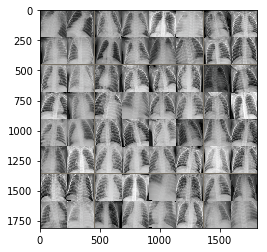

In [4]:
out = torchvision.utils.make_grid(features)


def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)


imshow(out)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features

model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(128, 2), nn.LogSoftmax(dim=1))

model.to(device)
weight = torch.tensor([0.7, 0.3]).to(device)
criterion = nn.CrossEntropyLoss(weight)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01)
num_epochs = 20

print(n_inputs)

4096


In [7]:
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Training

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    history = []

    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history.append(epoch_loss)
            history.append(epoch_acc)
            print('\nAcc: {:.5f}, Loss: {:.5f} in phase {}'
                  .format(epoch_acc, epoch_loss, phase))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:.5f}'.format(best_acc))

    model.load_state_dict(best_model_weights)
    return model, history

In [9]:
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

0%|          | 0/20 [00:00<?, ?it/s]
Acc: 0.72124, Loss: 0.64976 in phase train
  5%|▌         | 1/20 [02:05<39:50, 125.82s/it]
Acc: 0.75000, Loss: 0.64079 in phase val

Acc: 0.80464, Loss: 0.50346 in phase train
 10%|█         | 2/20 [04:07<37:23, 124.66s/it]
Acc: 0.81250, Loss: 0.55006 in phase val

Acc: 0.83762, Loss: 0.39448 in phase train
 15%|█▌        | 3/20 [06:09<35:06, 123.90s/it]
Acc: 0.81250, Loss: 0.47638 in phase val

Acc: 0.85813, Loss: 0.34918 in phase train
 20%|██        | 4/20 [08:11<32:52, 123.31s/it]
Acc: 0.87500, Loss: 0.37822 in phase val

Acc: 0.87078, Loss: 0.32455 in phase train
 25%|██▌       | 5/20 [10:14<30:44, 122.98s/it]
Acc: 0.93750, Loss: 0.30574 in phase val

Acc: 0.87826, Loss: 0.31260 in phase train
 30%|███       | 6/20 [12:16<28:38, 122.76s/it]
Acc: 0.93750, Loss: 0.28147 in phase val

Acc: 0.88075, Loss: 0.30652 in phase train
 35%|███▌      | 7/20 [14:18<26:33, 122.58s/it]
Acc: 0.93750, Loss: 0.29938 in phase val

Acc: 0.88765, Loss: 0.30148 in p

Now use extended slicing, such that the variables can be used for plotting the loss and accuracy of training and validation.

In [10]:
loss_train = [element for element in history[::4]]
acc_train = [element.item() for element in history[1::4]]
loss_val = [element for element in history[2::4]]
acc_val = [element.item() for element in history[3::4]]


In [11]:
print(len(acc_train), len(loss_train), len(acc_val), len(loss_val))

20 20 20 20


## Accuracy and Loss during training

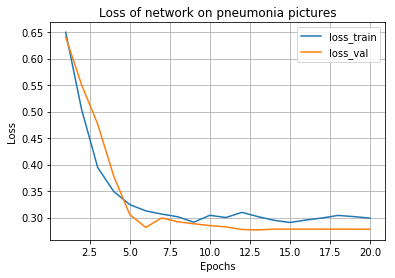

In [12]:
fig, ax = plt.subplots()
x = np.arange(1, num_epochs + 1)
ax.plot(x, loss_train, label='loss_train')
ax.plot(x, loss_val, label='loss_val')
ax.legend(loc='upper right')
ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss of network on pneumonia pictures')
ax.grid()

fig.savefig("loss.png")
plt.show()

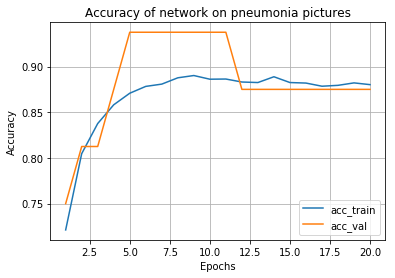

In [13]:
fig, ax = plt.subplots()
x = np.arange(1, num_epochs + 1)
ax.plot(x, acc_train, label='acc_train')
ax.plot(x, acc_val, label='acc_val')
plt.legend(loc='lower right')
ax.set(xlabel='Epochs', ylabel='Accuracy',
       title='Accuracy of network on pneumonia pictures')
ax.grid()

fig.savefig("accuracy.png")
plt.show()

## Predictions on the test set

In [14]:
test = dataloaders['test']
test_loss = 0.0
classes = [0, 1]
model.eval()

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for data, target in test:
        if len(target) != 64:  # batch size
            continue

        data = data.to(device)
        target = target.to(device)
        model.to(device)

        output = model(data)

        loss = criterion(output, target)

        test_loss += loss.item()*data.size(0)

        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())

        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / len(test.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {} ({}/{})'.format(
               classes[i], 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)'
             .format(classes[i]))

print('\nTest Accuracy (Overall): {} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.504318

Test Accuracy of 0: 65.15837104072398 (144.0/221.0)
Test Accuracy of 1: 90.98591549295774 (323.0/355.0)

Test Accuracy (Overall): 81.07638888888889 (467.0/576.0)


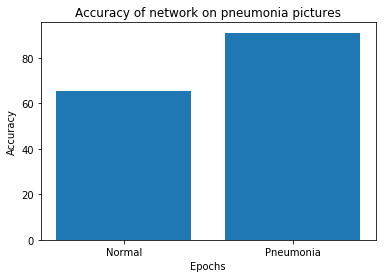

In [15]:
fig, ax = plt.subplots()
x = np.arange(1, 3)
y = [class_correct[0] / class_total[0] * 100, class_correct[1] /
     class_total[1] * 100]
ax.bar(x, y)

plt.xticks(x, ('Normal', 'Pneumonia'))
ax.set(xlabel='Epochs', ylabel='Accuracy',
       title='Accuracy of network on pneumonia pictures')

fig.savefig("accuracy_on_class.png")
plt.show()

In [16]:
print(class_correct)
print(class_total)
true_negative = class_correct[0]
true_positive = class_correct[1]
false_positive = (class_total[0] - class_correct[0])
false_negative = (class_total[1] - class_correct[1])

[144.0, 323.0]
[221.0, 355.0]


In [17]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)
negative_predictive_value = true_negative / (true_negative + false_negative)

print(precision, recall, specificity, negative_predictive_value)


0.8075 0.9098591549295775 0.6515837104072398 0.8181818181818182


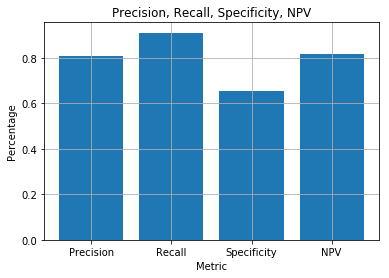

In [18]:
fig, ax = plt.subplots()
x = np.arange(1, 5)
y = [precision, recall, specificity, negative_predictive_value]
ax.bar(x, y)
plt.xticks(x, ('Precision', 'Recall', 'Specificity', 'NPV'))
ax.set(xlabel='Metric', ylabel='Percentage',
       title='Precision, Recall, Specificity, NPV')
ax.grid()

fig.savefig("metrics.png")
plt.show()

In [19]:
f1 = 2 * ((precision * recall) / (precision + recall))
print(f1)

0.8556291390728477


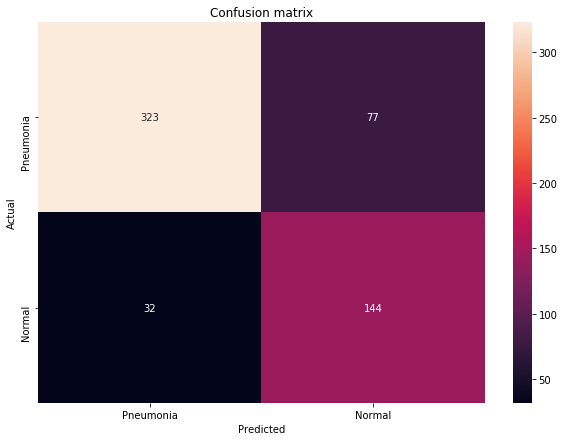

In [20]:
matrix = np.array([[true_positive, false_positive],
                  [false_negative, true_negative]])
matrix.astype(int)
df_cm = pd.DataFrame(matrix, index=['Pneumonia', 'Normal'],
                     columns=['Pneumonia', 'Normal'])
plt.figure(figsize=(10, 7))
plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusionmatrix.png')

In [21]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': criterion.state_dict(),
            'loss': loss,
            'scheduler': exp_lr_scheduler.state_dict(),
            'Accuracy test:': str(np.sum(class_correct)
                              / np.sum(class_total)),
            'Accuracy train:': str(acc_train),
            'Accuracy validation: ': str(acc_val),
            'Loss train': str(loss_train),
            'Loss val': str(loss_val),
            'F1': str(f1),
            'Precision': str(precision),
            'Recall': str(recall),
            'Class correct': str(class_correct),
            'Class total': str(class_total)
            }, 'model.pt')

In [22]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1